# Text Preprocessing

- Nama: Muhammad Habibulloh
- Email: habibmuhammadoct@gmail.com

## Import Library

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Dataset dari GitHub

#### Dataset Github merupakan hasil scraping pada tugas NLP sebelumnya yaitu saya mengambil data dari scraping portal berita detik.com, https://github.com/haaahabib/scraping-detik.com/blob/main/dataset.zip

In [7]:
import pandas as pd
import requests
import zipfile
import io

# URL GitHub
url = 'https://github.com/haaahabib/scraping-detik.com/raw/main/dataset.zip'

# Download the zip file
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses (like 404)

# Extract the csv file from the zip file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('berita.csv') as f:
        df = pd.read_csv(f)

df.head()

,judul,tanggal,konten,kategori
0,"THR PNS Dipastikan Cair Full, Pajak Ditanggung...",13 Mar 2025,Kementerian Keuangan (Kemenkeu) memastikan Tun...,finance
1,"Dunia Lagi Perang Dagang, Prabowo Beri Perinta...",13 Mar 2025,Kebijakan pengenaan tarif impor oleh Presiden ...,finance
2,"Soroti Perang Dagang AS & Kanada, Sri Mulyani ...",13 Mar 2025,Menteri Keuangan (Menkeu) Sri Mulyani menyebut...,finance
3,"Belanja Negara Tembus Rp 348,1 T dalam 2 Bulan...",13 Mar 2025,Kementerian Keuangan (Kemenkeu) melaporkan hin...,finance
4,Pelni Tak Beri Diskon Tiket saat Mudik Lebaran...,13 Mar 2025,PT Pelayaran Nasional Indonesia (Persero) atau...,finance


## Text Preprocessing

In [8]:
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenization
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('indonesian'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)
    else:
        # Handle non-string values
        return ''

# Terapkan fungsi text preprocessing pada kolom 'konten'
df['clean_text'] = df['konten'].apply(preprocess_text)

df[['konten', 'clean_text']].head()

,konten,clean_text
0,Kementerian Keuangan (Kemenkeu) memastikan Tun...,kementerian keuangan kemenkeu tunjangan raya t...
1,Kebijakan pengenaan tarif impor oleh Presiden ...,kebijakan pengenaan tarif impor presiden ameri...
2,Menteri Keuangan (Menkeu) Sri Mulyani menyebut...,menteri keuangan menkeu sri mulyani menyebut d...
3,Kementerian Keuangan (Kemenkeu) melaporkan hin...,kementerian keuangan kemenkeu melaporkan 28 fe...
4,PT Pelayaran Nasional Indonesia (Persero) atau...,pt pelayaran nasional indonesia persero pelni ...


## BoW dan TF-IDF

In [9]:
# Bag of Words (BoW)
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['clean_text'])

# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['clean_text'])

print("Shape of BoW matrix:", X_bow.shape)
print("Shape of TF-IDF matrix:", X_tfidf.shape)

Shape of BoW matrix: (8489, 76649)
Shape of TF-IDF matrix: (8489, 76649)


## Word Embeddings (Word2Vec)

In [10]:
sentences = [text.split() for text in df['clean_text']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Rata-rata Vektor
def get_average_word2vec(tokens_list, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in tokens_list:
        if word in model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

# Terapkan Word2Vec pada dataset
X_word2vec = np.array([get_average_word2vec(sentence, word2vec_model, 100) for sentence in sentences])
print("Shape of Word2Vec matrix:", X_word2vec.shape)

Shape of Word2Vec matrix: (8489, 100)


## Word Embeddings dengan t-SNE

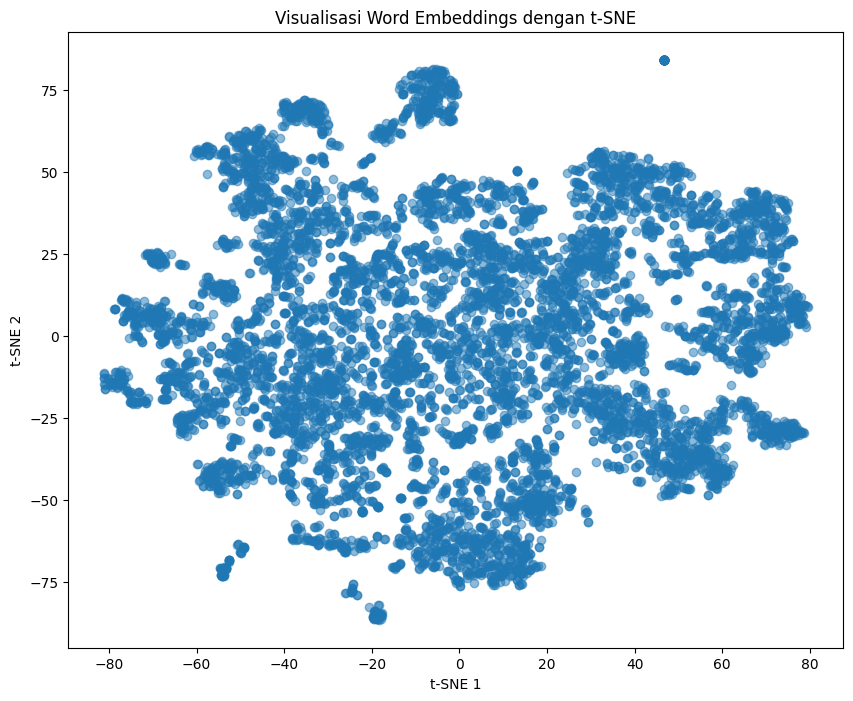

In [11]:
tsne = TSNE(n_components=2, random_state=42)
X_word2vec_tsne = tsne.fit_transform(X_word2vec)

# Plot hasil t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(X_word2vec_tsne[:, 0], X_word2vec_tsne[:, 1], alpha=0.5)
plt.title('Visualisasi Word Embeddings dengan t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## Performa Model dengan BoW, TF-IDF, dan Word Embeddings

In [12]:
# Data Splitting
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df['kategori'], test_size=0.3, random_state=42)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['kategori'], test_size=0.3, random_state=42)
X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(X_word2vec, df['kategori'], test_size=0.3, random_state=42)

# Model Naive Bayes untuk BoW
model_bow = MultinomialNB()
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)

# Model Naive Bayes untuk TF-IDF
model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# Model Logistic Regression untuk Word2Vec
model_word2vec = LogisticRegression(max_iter=1000)
model_word2vec.fit(X_train_word2vec, y_train)
y_pred_word2vec = model_word2vec.predict(X_test_word2vec)

In [13]:
print("Classification Report for BoW:")
print(classification_report(y_test, y_pred_bow))

Classification Report for BoW:
              precision    recall  f1-score   support

         edu       0.83      0.78      0.80       277
     finance       0.82      0.90      0.86       304
        food       0.91      0.91      0.91       274
      health       0.88      0.92      0.90       262
        inet       0.89      0.79      0.84       292
         oto       0.92      0.86      0.89       277
    properti       0.94      0.94      0.94       273
       sport       0.93      0.97      0.95       283
      travel       0.80      0.85      0.82       305

    accuracy                           0.88      2547
   macro avg       0.88      0.88      0.88      2547
weighted avg       0.88      0.88      0.88      2547



In [14]:
print("Classification Report for TF-IDF:")
print(classification_report(y_test, y_pred_tfidf))

Classification Report for TF-IDF:
              precision    recall  f1-score   support

         edu       0.87      0.74      0.80       277
     finance       0.82      0.88      0.85       304
        food       0.88      0.92      0.90       274
      health       0.86      0.94      0.90       262
        inet       0.92      0.75      0.82       292
         oto       0.90      0.86      0.88       277
    properti       0.87      0.96      0.91       273
       sport       0.91      0.98      0.94       283
      travel       0.83      0.82      0.83       305

    accuracy                           0.87      2547
   macro avg       0.87      0.87      0.87      2547
weighted avg       0.87      0.87      0.87      2547



In [15]:
print("Classification Report for Word2Vec:")
print(classification_report(y_test, y_pred_word2vec))

Classification Report for Word2Vec:
              precision    recall  f1-score   support

         edu       0.69      0.64      0.67       277
     finance       0.69      0.70      0.70       304
        food       0.84      0.87      0.86       274
      health       0.85      0.85      0.85       262
        inet       0.68      0.70      0.69       292
         oto       0.85      0.79      0.82       277
    properti       0.90      0.84      0.87       273
       sport       0.88      0.93      0.90       283
      travel       0.66      0.71      0.69       305

    accuracy                           0.78      2547
   macro avg       0.78      0.78      0.78      2547
weighted avg       0.78      0.78      0.78      2547



## Perbandingan Performa

<ipython-input-16-ec5723579acc>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Accuracy', data=results_df, palette='viridis')


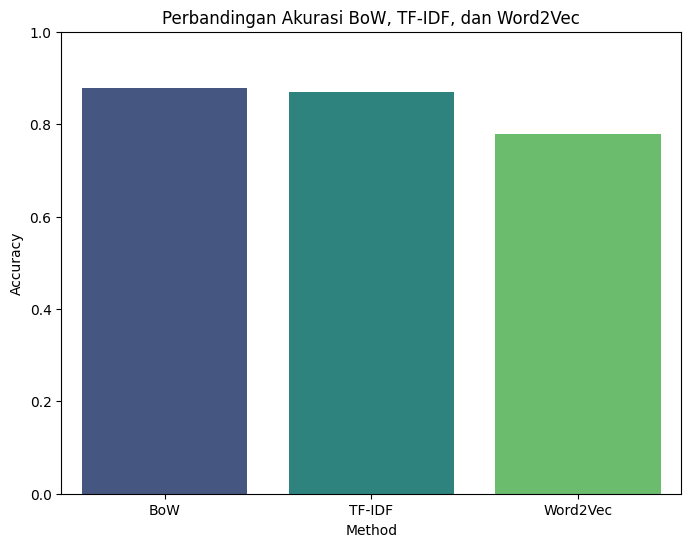

In [16]:
results = {
    'Method': ['BoW', 'TF-IDF', 'Word2Vec'],
    'Accuracy': [
        model_bow.score(X_test_bow, y_test),
        model_tfidf.score(X_test_tfidf, y_test),
        model_word2vec.score(X_test_word2vec, y_test)
    ]
}

results_df = pd.DataFrame(results)

# Perbandingan
plt.figure(figsize=(8, 6))
sns.barplot(x='Method', y='Accuracy', data=results_df, palette='viridis')
plt.title('Perbandingan Akurasi BoW, TF-IDF, dan Word2Vec')
plt.ylim(0, 1)
plt.show()

## Conclusion

**1. BoW (Bag of Words):**

- Akurasi 0.88

- BoW menunjukkan performa yang sangat baik dengan akurasi tertinggi di antara ketiga metode. Precision, recall, dan F1-score juga tinggi untuk hampir semua kategori.
---
**2. TF-IDF**

- Akurasi 0.87

- TF-IDF memiliki akurasi yang sedikit lebih rendah dibandingkan BoW, tetapi masih sangat bagus. Metode ini memberikan bobot lebih pada kata-kata penting, sehingga performanya stabil di berbagai kategori
---
**3. Word2Vec (Word Embeddings)**

- Akurasi 0.78

- Word2Vec memiliki akurasi yang lebih rendah dibandingkan BoW dan TF-IDF. Namun, metode ini menangkap makna semantik kata dan hubungan antar kata, sehingga performanya masih cukup baik untuk beberapa kategori seperti "food", "health", dan "sport".
---
Metode BoW adalah lebih baik daripada metode lainnya untuk dataset ini karena memberikan akurasi tertinggi dan performa yang konsisten di semua kategori